
# Volatility Forecasting from High‑Frequency Quotes


This notebook is written as a self‑contained chapter on volatility forecasting using high‑frequency crypto futures quotes. The central idea is to separate:

1. Measurement of ex‑post variation using high‑frequency data (realized and range‑based measures), from
2. Modeling the conditional variance (or a proxy for it) to produce ex‑ante forecasts.

We proceed in a deliberately structured hierarchy:

**(i) Variance proxies / targets**
- Squared returns (always available, very noisy)
- Realized variance (preferred when intraday data are available)
- Range‑based estimators (OHLC‑based)

**(ii) Baselines**
- Rolling averages of squared returns
- Exponentially weighted moving average (EWMA / RiskMetrics‑style)

**(iii) Conditional heteroskedasticity models**
- GARCH(1,1) and asymmetric extensions (GJR‑GARCH, EGARCH)

**(iv) Realized‑volatility regressions**
- HAR‑RV models (long‑memory approximations that exploit realized measures)

**(v) Latent‑volatility and regime models**
- Approximate stochastic volatility via a Gaussian state‑space representation + Kalman filter
- Markov regime‑switching variance

**(vi) Proper out‑of‑sample evaluation**
- Proper scoring rules for variance forecasts (notably QLIKE)
- Calibration and cumulative loss diagnostics

 ## Data expectations
 This notebook expects local quote files produced by Tardis (or an equivalent data export) such as:
 - `tardis_binance_btc/binance-futures_quotes_YYYY-MM-DD_BTCUSDT.csv`


## Notation and forecasting protocol
Let $m_t$ denote the midquote price at time $t$, and let $p_t=\log m_t$ be the log‑price.

- Bar returns (modeling grid):
  $$
  r_t \;=\; p_t - p_{t-1}.
  $$
- Conditional variance (the latent object we aim to forecast):
  $$
  h_t \;=\; \operatorname{Var}(r_t \mid \mathcal{F}_{t-1}),
  $$
  where $\mathcal{F}_{t-1}$ is the information set available at the previous bar close.

- Realized variance (measurement from high‑frequency returns):
  If $\{r_{t,i}\}_{i=1}^{M_t}$ are base‑frequency returns inside bar $t$, the realized variance is
  $$
  RV_t \;=\; \sum_{i=1}^{M_t} r_{t,i}^2.
  $$

- Forecast target (next‑bar realized variance):
  $$
  y_t \;=\; RV_{t+1}.
  $$
  A forecast $\hat h_t$ stored at index $t$ is interpreted as the one‑step‑ahead forecast $\hat h_{t+1\mid t}$.

Throughout, we work in percent log‑return units for numerical stability:
$$
r_t^{(\%)} = 100\, r_t,\qquad
RV_t^{(\%^2)} = 100^2\, RV_t.
$$
This changes units, not substance: scaling returns by a constant scales variance by the constant squared.


 ## 0. Setup

 We import the scientific Python stack used for:
 - data handling (pandas, numpy),
 - visualization (matplotlib),
 - linear models and time‑series diagnostics (statsmodels),
 - likelihood‑based estimation (scipy.optimize).

In [26]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from scipy.optimize import minimize

## 0.1 Configuration: two time scales and consistent units

High‑frequency volatility work typically requires two grids:

1. A base grid used to construct realized measures (e.g., `BASE_FREQ="1s"`).
2. A modeling grid used for forecasting and evaluation (e.g., `BAR_FREQ="5min"`).

The modeling question is: *given information at the close of bar $t$, forecast variance over bar $t+1$.*
Using right‑labeled, right‑closed bars makes this alignment explicit: the timestamp on each bar is its close.

### Why scale returns?
High‑frequency log returns can be extremely small in magnitude. Many likelihood optimizers behave better numerically when inputs have order‑one scale. We therefore work with:
$$
r_t^{(\%)} = 100 \cdot r_t,
$$
and scale all variance proxies by $100^2$ accordingly so that comparisons remain coherent.

In [27]:
DATA_DIR = Path("tardis_binance_btc")
SYMBOL = "BTCUSDT"

BASE_FREQ = "1s"
BAR_FREQ  = "5min"

RETURN_SCALE = 100.0

QUOTES_GLOB = str(DATA_DIR / f"binance-futures_quotes_*_{SYMBOL}.csv")

quote_files = sorted(glob.glob(QUOTES_GLOB))

print("Quotes files:", len(quote_files))

Quotes files: 6


## 0.2 High‑frequency quote handling and microstructure cleaning

In limit order markets, the raw quote stream can contain observations that are not economically meaningful as tradable quotes:

- Locked quotes: best ask equals best bid ($a_t=b_t$), implying zero spread.
- Crossed quotes: best ask below best bid ($a_t<b_t$), implying negative spread.

In a frictionless market these would invite immediate arbitrage, but in practice they can arise from several areas.

For volatility measurement, locked/crossed quotes can produce pathological midprices and returns. A standard defensive preprocessing step is therefore to discard such observations before resampling.

We compute:
- Midquote: $m_t=\tfrac{1}{2}(b_t+a_t)$
- Spread: $s_t=a_t-b_t$
- Level‑1 imbalance:
  $$
  \text{imb}_t=\frac{q^b_t-q^a_t}{q^b_t+q^a_t},
  $$
  where $q^b_t, q^a_t$ are the best‑bid and best‑ask sizes. (This is included as a potential explanatory variable; it is not required by the classical volatility models below.)

The helper functions below implement these steps and enforce consistent time indexing.

In [28]:
def _to_dt_us(x: pd.Series) -> pd.DatetimeIndex:
    return pd.to_datetime(x.astype("int64"), unit="us", utc=True)

def load_quotes_mid(paths, chunksize=None, drop_crossed=True):

    usecols = ["timestamp", "bid_price", "ask_price", "bid_amount", "ask_amount"]
    dtypes = {
        "timestamp": "int64",
        "bid_price": "float64",
        "ask_price": "float64",
        "bid_amount": "float64",
        "ask_amount": "float64",
    }
    frames = []
    for p in paths:
        if chunksize is None:
            df = pd.read_csv(p, usecols=usecols, dtype=dtypes)
            df["dt"] = _to_dt_us(df["timestamp"])
            df = df.set_index("dt").sort_index()
            frames.append(df)
        else:
            reader = pd.read_csv(p, usecols=usecols, dtype=dtypes, chunksize=chunksize)
            for chunk in reader:
                chunk["dt"] = _to_dt_us(chunk["timestamp"])
                chunk = chunk.set_index("dt")
                frames.append(chunk)

    df = pd.concat(frames).sort_index()
    df = df[~df.index.duplicated(keep="last")]

    # Basic cleaning
    df = df[(df["bid_price"] > 0) & (df["ask_price"] > 0)].copy()
    df["spread"] = df["ask_price"] - df["bid_price"]
    crossed = (df["spread"] <= 0).sum()
    if drop_crossed:
        df = df[df["spread"] > 0].copy()

    df["mid"] = 0.5 * (df["bid_price"] + df["ask_price"])
    df["imbalance_L1"] = (df["bid_amount"] - df["ask_amount"]) / (df["bid_amount"] + df["ask_amount"] + 1e-12)

    info = {
        "rows_after_concat": int(sum(1 for _ in frames)) if chunksize is not None else None,
        "crossed_or_locked_quotes": int(crossed),
        "final_rows": int(len(df)),
    }
    return df[["bid_price","ask_price","bid_amount","ask_amount","mid","spread","imbalance_L1"]], info

def make_time_bars_from_mid(mid_df: pd.DataFrame, freq: str):

    mid = mid_df["mid"].copy()
    ohlc = mid.resample(freq, label="right", closed="right").ohlc()
    spread = mid_df["spread"].resample(freq, label="right", closed="right").last().rename("spread")
    imb = mid_df["imbalance_L1"].resample(freq, label="right", closed="right").last().rename("imbalance_L1")
    out = ohlc.join([spread, imb], how="left")
    return out

def compute_log_returns_from_close(close: pd.Series) -> pd.Series:
    close = close.replace([0, np.inf, -np.inf], np.nan).dropna()
    return np.log(close).diff().dropna()

def realized_variance_from_base_returns(ret_base: pd.Series, bar_freq: str) -> pd.Series:
    return ret_base.pow(2).resample(bar_freq, label="right", closed="right").sum().dropna()

## 0.3 Building the two grids and defining realized variance

We now construct:

- A base‑frequency midquote series $m_{t_i}$ sampled every `BASE_FREQ`, producing base returns $r_{t_i}$.
- A bar‑frequency OHLC series (on `BAR_FREQ`) producing modeling returns $r_t$.

### Realized variance and integrated variance (the central measurement idea)
In continuous‑time finance, a standard stylized model for the efficient log‑price is an Itô semimartingale:
$$
dp_t = \mu_t\,dt + \sigma_t\,dW_t,
$$
where $\sigma_t$ is the instantaneous volatility. Over an interval $[t, t+\Delta]$, the integrated variance is
$$
IV_{t,t+\Delta} = \int_t^{t+\Delta} \sigma_s^2\,ds.
$$
A fundamental result in realized volatility theory is that, absent market microstructure noise and under mild conditions,
$$
RV_{t,t+\Delta} = \sum_{i=1}^{M} (p_{t_i}-p_{t_{i-1}})^2 \;\xrightarrow[M\to\infty]{}\; IV_{t,t+\Delta},
$$
i.e., realized variance estimates the quadratic variation of the efficient price.

In practice, at very high sampling frequencies, market microstructure noise can bias RV upward. This motivates our later “signature‑style” sensitivity check across base sampling frequencies.

 Finally, we work in percent‑squared units:
 - `ret_pct = 100 * ret`
 - `RV_pct2 = 100^2 * RV`

In [29]:
mid_tick, info = load_quotes_mid(quote_files, chunksize=None, drop_crossed=True)
print("Loaded tick rows:", len(mid_tick))
print("Crossed/locked quotes found (dropped):", info["crossed_or_locked_quotes"])
print(mid_tick.head())

mid_base = mid_tick["mid"].resample(BASE_FREQ, label="right", closed="right").last().ffill()
ret_base = compute_log_returns_from_close(mid_base)

bars = make_time_bars_from_mid(mid_tick, BAR_FREQ).dropna(subset=["close"])
bars["ret"] = compute_log_returns_from_close(bars["close"])
bars["ret_pct"] = RETURN_SCALE * bars["ret"]

rv_bar = realized_variance_from_base_returns(ret_base, BAR_FREQ)
bars = bars.join(rv_bar.rename("RV"), how="inner")
bars["RV_pct2"] = (RETURN_SCALE**2) * bars["RV"]

df = bars.dropna(subset=["ret_pct","RV_pct2"]).copy()

print(df[["open","high","low","close","spread","ret_pct","RV_pct2"]].head())
print("Bars:", len(df), "| span:", df.index.min(), "→", df.index.max())

Loaded tick rows: 7597095
Crossed/locked quotes found (dropped): 0
                                  bid_price  ask_price  bid_amount  \
dt                                                                   
2025-11-15 00:00:00.783000+00:00    94550.8    94550.9       6.347   
2025-11-15 00:00:01.097000+00:00    94552.8    94552.9       6.593   
2025-11-15 00:00:01.150000+00:00    94552.8    94552.9       6.010   
2025-11-15 00:00:01.201000+00:00    94552.8    94552.9       5.810   
2025-11-15 00:00:01.253000+00:00    94552.8    94552.9       3.584   

                                  ask_amount       mid  spread  imbalance_L1  
dt                                                                            
2025-11-15 00:00:00.783000+00:00       0.009  94550.85     0.1      0.997168  
2025-11-15 00:00:01.097000+00:00       0.612  94552.85     0.1      0.830118  
2025-11-15 00:00:01.150000+00:00       0.766  94552.85     0.1      0.773908  
2025-11-15 00:00:01.201000+00:00       1.942  9

 ## 0.4 First look: price, spread, and volatility clustering

 Before fitting any model, we validate basic empirical regularities:

 - Volatility clustering: large returns tend to be followed by large returns; this appears as positive autocorrelation in $r_t^2$.
 - Microstructure diagnostics: spreads and their distribution help identify illiquid regimes, data issues, or regime changes.

 The ACF of squared returns is a simple visual diagnostic consistent with ARCH effects, motivating the GARCH family.

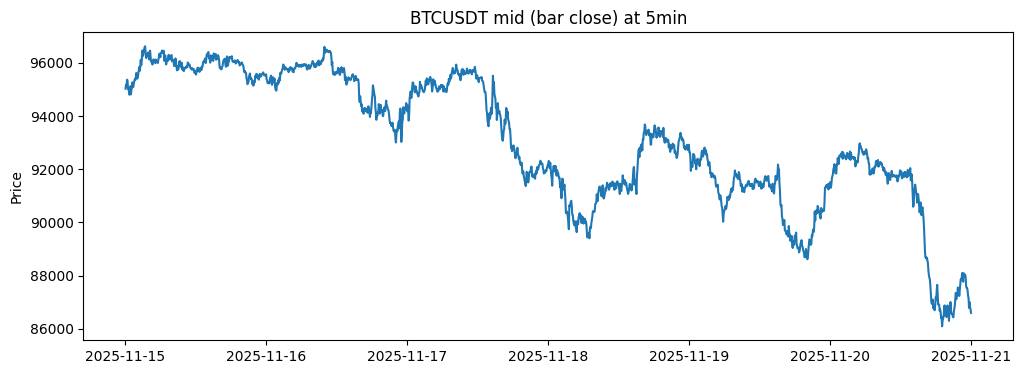

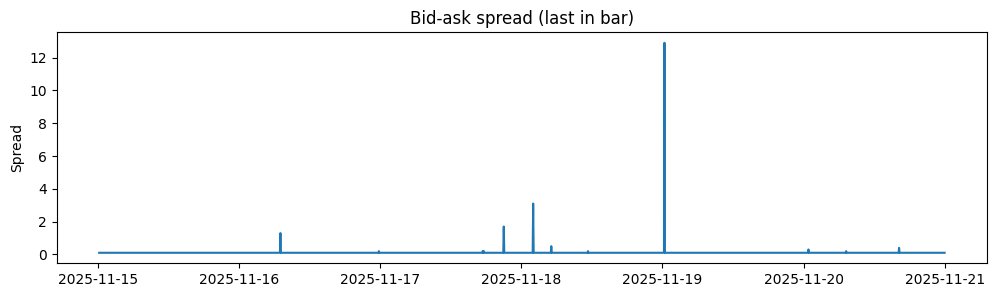

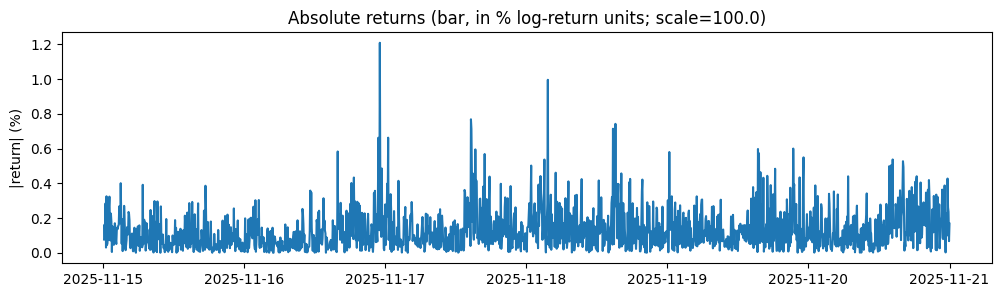

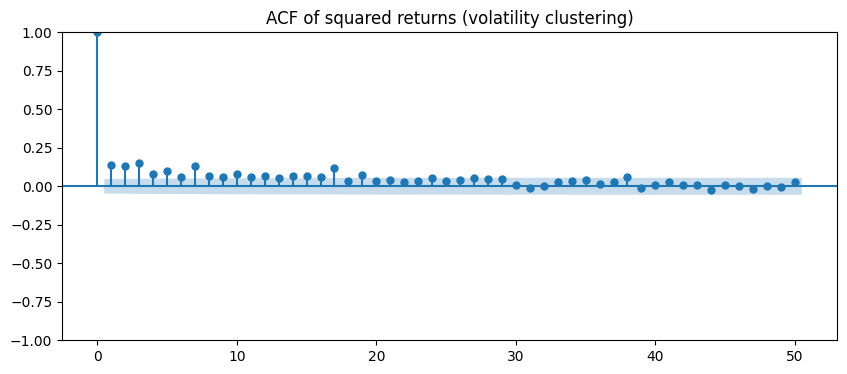

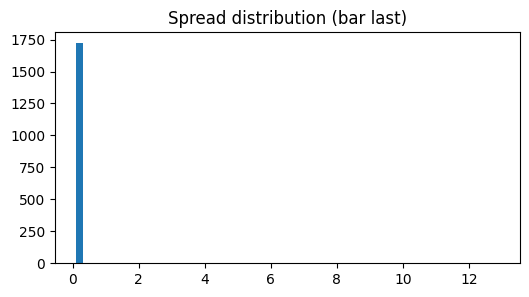

In [30]:
# %%

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, df["close"])
ax.set_title(f"{SYMBOL} mid (bar close) at {BAR_FREQ}")
ax.set_ylabel("Price")
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.index, df["spread"])
ax.set_title("Bid-ask spread (last in bar)")
ax.set_ylabel("Spread")
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(df.index, df["ret_pct"].abs())
ax.set_title(f"Absolute returns (bar, in % log-return units; scale={RETURN_SCALE})")
ax.set_ylabel("|return| (%)")
plt.show()

fig = plt.figure(figsize=(10, 4))
plot_acf((df["ret_pct"]**2), lags=50, ax=plt.gca())
plt.title("ACF of squared returns (volatility clustering)")
plt.show()

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df["spread"].dropna(), bins=60)
ax.set_title("Spread distribution (bar last)")
plt.show()

# 1. Variance proxies and targets

## 1.1 Why we need “variance proxies”
The object of interest in most volatility models is the conditional variance $h_t = \operatorname{Var}(r_t\mid\mathcal{F}_{t-1})$, which is latent.

For forecast evaluation we therefore need an observable proxy for the variance realized over the forecast horizon.

Two standard proxies on the bar horizon are:

1. Squared return: $r_t^2$
   - available at all frequencies,
   - but extremely noisy as a variance proxy (high measurement error).

2. Realized variance: $RV_t$ built from higher‑frequency returns within the bar
   - typically much closer to integrated variance than $r_t^2$,
   - but sensitive to microstructure noise at extremely high sampling rates.

In this notebook, the primary evaluation target is next‑bar realized variance:
$$
y_t = RV_{t+1}^{(\%^2)}.
$$

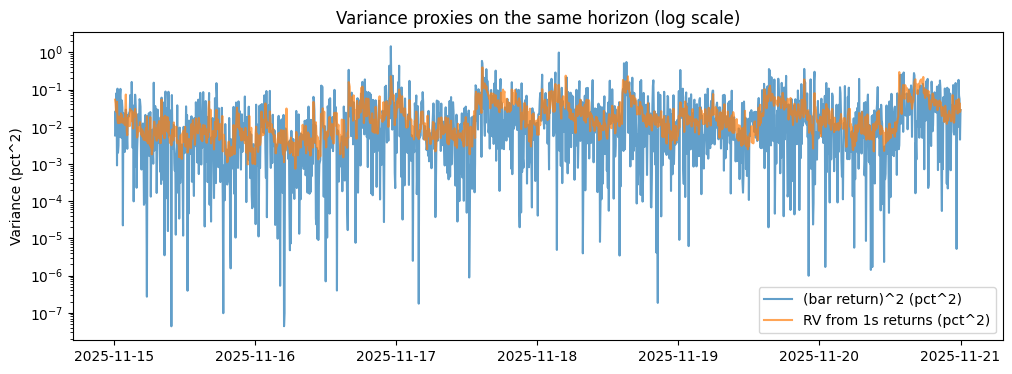

Corr(r^2, RV): 0.4938983677537232


In [31]:
df["r2_pct2"] = df["ret_pct"]**2

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, df["r2_pct2"], label="(bar return)^2 (pct^2)", alpha=0.7)
ax.plot(df.index, df["RV_pct2"], label=f"RV from {BASE_FREQ} returns (pct^2)", alpha=0.7)
ax.set_yscale("log")
ax.set_title("Variance proxies on the same horizon (log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend()
plt.show()

print("Corr(r^2, RV):", df["r2_pct2"].corr(df["RV_pct2"]))

## 1.2 Range-based variance estimators (OHLC)

High-frequency data are not always available, and even when they are, microstructure noise can complicate extremely fine sampling. A complementary class of variance proxies uses only OHLC information within each bar. These estimators exploit the fact that, under idealized continuous-time diffusions, the range contains information about variance.

Let $O_t, H_t, L_t, C_t$ denote open/high/low/close prices within bar $t$. We consider log ratios such as $\log(H_t / L_t)$.

Common estimators (in log-return variance units) include:

### Parkinson
Under driftless Brownian motion,
$$
\widehat{\sigma^2}_t^{P} = \frac{1}{4\log 2} \left( \log \frac{H_t}{L_t} \right)^2.
$$

### Garman–Klass
Uses both range and open-to-close return:
$$
\widehat{\sigma^2}_t^{GK}
= \frac{1}{2} \left(\log \frac{H_t}{L_t}\right)^2
- \left(2\log 2 - 1\right)\left(\log \frac{C_t}{O_t}\right)^2.
$$

### Rogers–Satchell
Robust to nonzero drift:
$$
\widehat{\sigma^2}_t^{RS}
= \log\left(\frac{H_t}{O_t}\right)\left(\log\left(\frac{H_t}{O_t}\right) - \log\left(\frac{C_t}{O_t}\right)\right)
+ \log\left(\frac{L_t}{O_t}\right)\left(\log\left(\frac{L_t}{O_t}\right) - \log\left(\frac{C_t}{O_t}\right)\right).
$$

We compute these in log-variance units and then convert to percent-squared units by multiplying by `RETURN_SCALE^2`.

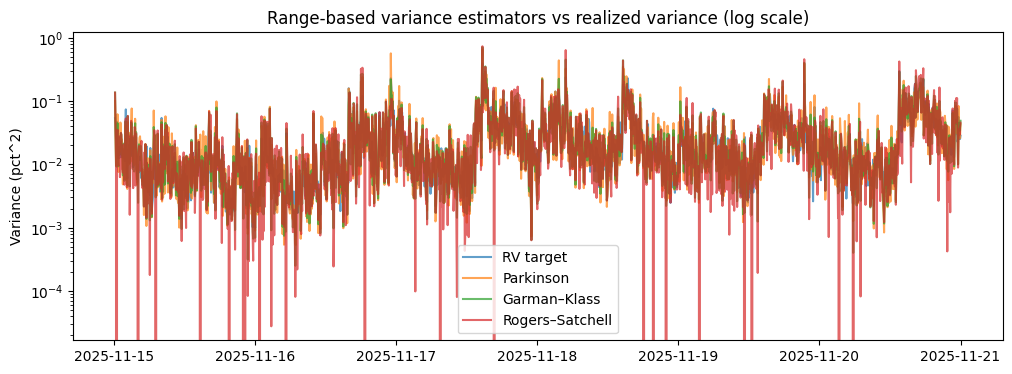

           RV_pct2  parkinson_pct2      gk_pct2      rs_pct2
count  1727.000000     1727.000000  1727.000000  1727.000000
mean      0.025385        0.029194     0.028577     0.028922
std       0.032477        0.044000     0.043475     0.047811
min       0.000745        0.000534     0.000251     0.000000
50%       0.013858        0.015078     0.014289     0.013801
90%       0.057994        0.067297     0.067479     0.067603
99%       0.164990        0.201270     0.217279     0.210986
max       0.395119        0.648549     0.706499     0.732038


In [32]:
def parkinson_var(ohlc: pd.DataFrame) -> pd.Series:
    hl = np.log(ohlc["high"] / ohlc["low"])
    return (hl**2) / (4.0 * np.log(2.0))

def garman_klass_var(ohlc: pd.DataFrame) -> pd.Series:
    hl = np.log(ohlc["high"] / ohlc["low"])
    co = np.log(ohlc["close"] / ohlc["open"])
    return 0.5 * (hl**2) - (2.0*np.log(2.0) - 1.0) * (co**2)

def rogers_satchell_var(ohlc: pd.DataFrame) -> pd.Series:
    ho = np.log(ohlc["high"] / ohlc["open"])
    lo = np.log(ohlc["low"] / ohlc["open"])
    co = np.log(ohlc["close"] / ohlc["open"])
    return ho*(ho - co) + lo*(lo - co)

df["parkinson_pct2"] = (RETURN_SCALE**2) * parkinson_var(df)
df["gk_pct2"] = (RETURN_SCALE**2) * garman_klass_var(df)
df["rs_pct2"] = (RETURN_SCALE**2) * rogers_satchell_var(df)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, df["RV_pct2"], label="RV target", alpha=0.7)
ax.plot(df.index, df["parkinson_pct2"], label="Parkinson", alpha=0.7)
ax.plot(df.index, df["gk_pct2"], label="Garman–Klass", alpha=0.7)
ax.plot(df.index, df["rs_pct2"], label="Rogers–Satchell", alpha=0.7)
ax.set_yscale("log")
ax.set_title("Range-based variance estimators vs realized variance (log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend()
plt.show()

print(df[["RV_pct2","parkinson_pct2","gk_pct2","rs_pct2"]].describe(percentiles=[0.5, 0.9, 0.99]))

## 1.3 Sampling-frequency sensitivity (“signature-style” check)

Realized variance has an asymptotic interpretation as sampling becomes dense, but in real markets the observed price includes microstructure effects (bid-ask bounce, discreteness, latency, and other frictions). A practical consequence is:

- Sampling *too frequently* can *inflate* realized variance due to noise.
- Sampling *too sparsely* can *miss* intrabar variation.

A classic diagnostic is a **signature plot**, which studies realized variance as a function of sampling interval. Here we do a simpler but informative check: compute RV using multiple base sampling frequencies and compare their correlations to the `1s` RV.

The goal is not to “prove” an optimal frequency, but to detect obvious instabilities and to choose a base grid that is empirically reasonable for the dataset at hand.

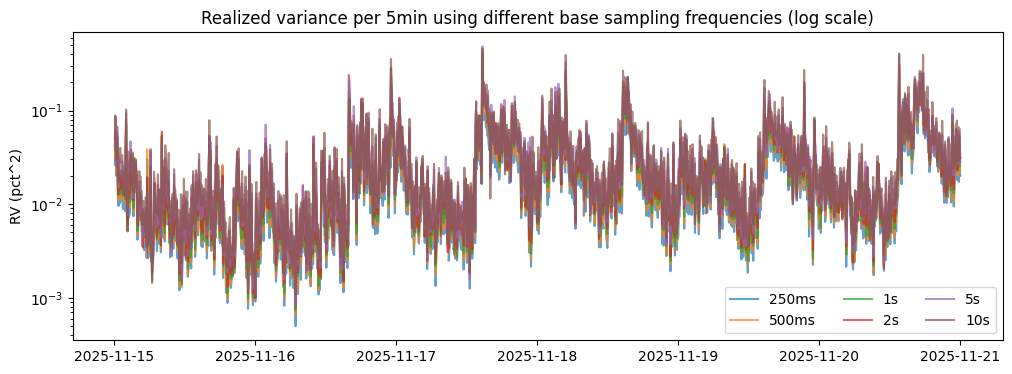

Correlation to 1s RV:
1s       1.000000
500ms    0.995668
2s       0.992828
250ms    0.987042
5s       0.976137
10s      0.945856
Name: 1s, dtype: float64


In [33]:
# %%

def rv_at_basefreq(mid_tick: pd.DataFrame, base_freq: str, bar_freq: str) -> pd.Series:
    mid_base = mid_tick["mid"].resample(base_freq, label="right", closed="right").last().ffill()
    ret_base = compute_log_returns_from_close(mid_base)
    return realized_variance_from_base_returns(ret_base, bar_freq)

base_freqs = ["250ms", "500ms", "1s", "2s", "5s", "10s"]
rv_compare = pd.DataFrame({bf: rv_at_basefreq(mid_tick, bf, BAR_FREQ) for bf in base_freqs}).dropna()
rv_compare_pct2 = (RETURN_SCALE**2) * rv_compare

fig, ax = plt.subplots(figsize=(12, 4))
for bf in base_freqs:
    ax.plot(rv_compare_pct2.index, rv_compare_pct2[bf], label=bf, alpha=0.7)
ax.set_yscale("log")
ax.set_title(f"Realized variance per {BAR_FREQ} using different base sampling frequencies (log scale)")
ax.set_ylabel("RV (pct^2)")
ax.legend(ncol=3)
plt.show()

if "1s" in rv_compare.columns:
    corr_to_1s = rv_compare.corr()["1s"].sort_values(ascending=False)
    print("Correlation to 1s RV:")
    print(corr_to_1s)


# 2. Baseline variance forecasts: rolling averages and EWMA

## 2.1 The forecasting target and alignment

We evaluate one-step-ahead variance forecasts on the bar grid. The realized-variance target is:
$$
y_t = RV_{t+1}^{(\%^2)}
$$
A forecast $\hat{h}_t$ stored at time $t$ is interpreted as $\hat{h}_{t+1 \mid t}$, i.e., the forecast formed using information available at the close of bar $t$.

Two baseline forecasters are:

### (a) Rolling mean of squared returns
$$
\hat{h}_{t+1 \mid t}^{\text{roll}} = \frac{1}{W} \sum_{j=0}^{W-1} \left(r_{t-j}^{(\%)}\right)^2
$$

### (b) EWMA / exponential smoothing

The canonical recursion for conditional variance is:
$$
h_t = \lambda h_{t-1} + (1-\lambda)\left(r_{t-1}^{(\%)}\right)^2
$$
with one-step-ahead forecast after observing $r_t$:
$$
h_{t+1 \mid t} = \lambda h_t + (1-\lambda)\left(r_t^{(\%)}\right)^2
$$

EWMA is not a full structural model of volatility dynamics, but it often performs surprisingly well as a benchmark and provides intuition about persistence and effective memory (half-life).



## 2.2 Train/test split without target leakage

Because the target uses a lead, $RV_{t+1}$, careless splitting can leak information across the boundary:
- If one shifts the target on the full dataset and then splits, the last training observation may "peek" into the first test target.

To avoid this, we:
1. Split the unshifted data into train/test.
2. Construct the one-step-ahead target within each split.


In [34]:
df_model = df[["ret_pct","RV_pct2","r2_pct2","parkinson_pct2","gk_pct2","rs_pct2","spread","imbalance_L1"]].copy()

split_frac = 0.7
split_idx = int(len(df_model) * split_frac)
train_raw = df_model.iloc[:split_idx].copy()
test_raw  = df_model.iloc[split_idx:].copy()

train_raw["target_RV_next"] = train_raw["RV_pct2"].shift(-1)
test_raw["target_RV_next"]  = test_raw["RV_pct2"].shift(-1)

train = train_raw.dropna()
test  = test_raw.dropna()

df_model["target_RV_next"] = df_model["RV_pct2"].shift(-1)

print("Train:", train.index.min(), "→", train.index.max(), "| n=", len(train))
print("Test :", test.index.min(), "→", test.index.max(),  "| n=", len(test))

Train: 2025-11-15 00:10:00+00:00 → 2025-11-19 04:40:00+00:00 | n= 1207
Test : 2025-11-19 04:50:00+00:00 → 2025-11-20 23:55:00+00:00 | n= 518



## 2.3 Rolling variance forecasts

Rolling windows implement a simple "local stationarity" assumption: over a short enough window $W$, the variance is approximately constant. Different $W$ values represent different degrees of smoothness:

- small $W$: reacts quickly, but noisy;
- large $W$: stable, but slow to adapt.


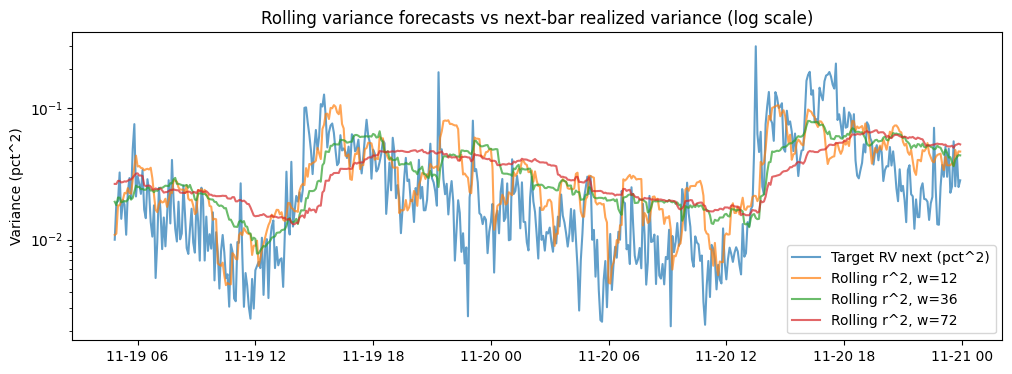

In [35]:
def rolling_var_forecast(ret_pct: pd.Series, window: int) -> pd.Series:
    return ret_pct.pow(2).rolling(window=window).mean()

windows = [12, 36, 72]
for w in windows:
    df_model[f"roll_{w}"] = rolling_var_forecast(df_model["ret_pct"], w)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test.index, test["target_RV_next"], label="Target RV next (pct^2)", alpha=0.7)
for w in windows:
    ax.plot(test.index, df_model.loc[test.index, f"roll_{w}"], label=f"Rolling r^2, w={w}", alpha=0.7)
ax.set_yscale("log")
ax.set_title("Rolling variance forecasts vs next-bar realized variance (log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend()
plt.show()


## 2.4 EWMA variance forecasts and half-life interpretation

EWMA can be interpreted as a geometrically weighted average of past squared returns:
$$
h_{t+1|t} = (1-\lambda)\sum_{j=0}^{\infty}\lambda^{j}\left(r_{t-j}^{(\%)}\right)^2
$$
so $\lambda$ controls the effective memory. A convenient summary is the half-life $L$ satisfying $\lambda^{L}=1/2$:
$$
L=\frac{\log(1/2)}{\log(\lambda)}
$$
This is reported below in units of bars (and converted to time via `BAR_FREQ`).


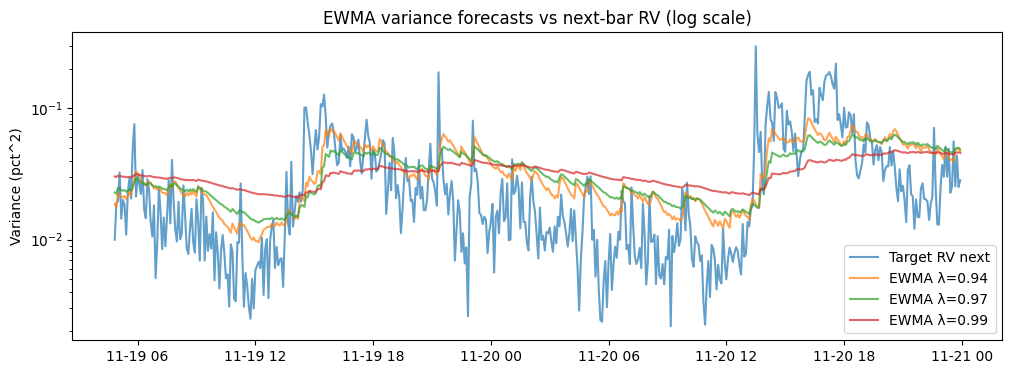

λ=0.94: half-life ≈ 11.20 bars (0 days 00:56:00.691675086)
λ=0.97: half-life ≈ 22.76 bars (0 days 01:53:46.971918832)
λ=0.99: half-life ≈ 68.97 bars (0 days 05:44:50.269180958)


In [36]:
def ewma_variance(ret_pct: pd.Series, lam: float, init_var=None) -> pd.Series:
    r2 = ret_pct.pow(2).values
    h = np.empty_like(r2)
    if init_var is None:
        init_var = np.nanmean(r2[:100]) if len(r2) > 100 else np.nanmean(r2)
    h[0] = max(init_var, 1e-12)
    for t in range(1, len(r2)):
        h[t] = lam * h[t-1] + (1.0 - lam) * r2[t-1]
    return pd.Series(h, index=ret_pct.index)

def ewma_variance_next(ret_pct: pd.Series, lam: float, init_var=None) -> pd.Series:
    h_t = ewma_variance(ret_pct, lam, init_var=init_var)
    r2_t = ret_pct.pow(2)
    return lam * h_t + (1.0 - lam) * r2_t

lams = [0.94, 0.97, 0.99]
for lam in lams:
    df_model[f"ewma_{lam}_fcst"] = ewma_variance_next(df_model["ret_pct"], lam)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test.index, test["target_RV_next"], label="Target RV next", alpha=0.7)
for lam in lams:
    ax.plot(test.index, df_model.loc[test.index, f"ewma_{lam}_fcst"], label=f"EWMA λ={lam}", alpha=0.7)
ax.set_yscale("log")
ax.set_title("EWMA variance forecasts vs next-bar RV (log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend()
plt.show()

for lam in lams:
    half_life = np.log(0.5) / np.log(lam)
    print(f"λ={lam}: half-life ≈ {half_life:.2f} bars ({half_life * pd.Timedelta(BAR_FREQ)})")


## 2.5 Tuning EWMA via QLIKE: a proper scoring rule for variance

Evaluating variance forecasts requires care because the "target" (realized variance) is itself noisy. A widely used criterion is the QLIKE loss, which is closely related to the Gaussian quasi-likelihood and is robust to certain forms of measurement noise in realized variance.

For realized target $y_t > 0$ and forecast $h_t > 0$, define:
$$
\ell_{\mathrm{QLIKE}}(y_t, h_t) = \frac{y_t}{h_t} - \log\left(\frac{y_t}{h_t}\right) - 1.
$$
This loss is minimized (in expectation) by the true conditional variance under standard conditions, making it a proper scoring rule for variance forecasts.

We choose $\lambda$ by minimizing average QLIKE on the training split.


Best λ on grid: 0.8570505050505051


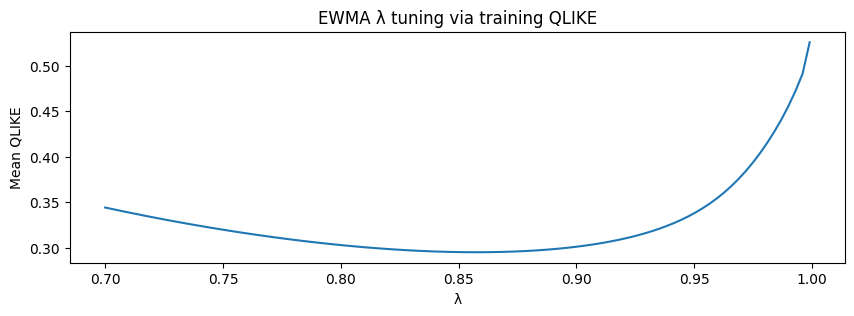

In [37]:
def qlike_loss(y_true: pd.Series, y_pred: pd.Series, eps=1e-12) -> float:
    y = np.maximum(y_true.values, eps)
    h = np.maximum(y_pred.values, eps)
    ratio = y / h
    return float(np.mean(ratio - np.log(ratio) - 1.0))

def ewma_qlike_objective(lam, ret_train, target_train):
    lam = float(lam)
    if not (0.0 < lam < 1.0):
        return 1e9
    h = ewma_variance_next(ret_train, lam)
    aligned = pd.concat([target_train, h], axis=1).dropna()
    return qlike_loss(aligned.iloc[:,0], aligned.iloc[:,1])

lam_grid = np.linspace(0.70, 0.999, 100)
losses = [ewma_qlike_objective(lam, train["ret_pct"], train["target_RV_next"]) for lam in lam_grid]
best_lam = float(lam_grid[int(np.argmin(losses))])
print("Best λ on grid:", best_lam)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(lam_grid, losses)
ax.set_title("EWMA λ tuning via training QLIKE")
ax.set_xlabel("λ")
ax.set_ylabel("Mean QLIKE")
plt.show()

df_model["ewma_tuned_fcst"] = ewma_variance_next(df_model["ret_pct"], best_lam)


# 3. GARCH family: conditional heteroskedasticity models

## 3.1 Motivation: modeling conditional variance directly
Volatility clustering suggests that
$$
\mathbb{E}\left[r_t^2\mid\mathcal{F}_{t-1}\right]
$$
varies over time in a persistent way. The ARCH/GARCH family models this persistence via a recursion for conditional variance.

### GARCH(1,1)
The canonical specification is
$$
r_t = \sqrt{h_t}\,\varepsilon_t, \qquad \varepsilon_t\sim \text{i.i.d. }(0,1),
$$
$$
h_t = \omega + \alpha r_{t-1}^2 + \beta h_{t-1},
$$
with constraints $\omega>0$, $\alpha\ge 0$, $\beta\ge 0$, and $\alpha+\beta<1$ for covariance stationarity.

### Quasi-maximum likelihood (QML)
Even if $\varepsilon_t$ is not Gaussian (often true in practice), estimating parameters by maximizing a Gaussian likelihood is common and yields consistent estimators under broad conditions when the conditional mean is correctly specified (here taken as zero at high frequency).

The code below implements:
- Gaussian negative log-likelihood,
- variance filtering recursions for GARCH(1,1) and GJR-GARCH.

A key practical point is that we enforce constraints by **reparameterization**: we optimize over unconstrained parameters and map them into admissible $(\omega,\alpha,\beta)$. This avoids numerical issues associated with constrained optimization while preserving the intended model class.


In [38]:
def gaussian_nll(r: np.ndarray, h: np.ndarray):
    h = np.maximum(h, 1e-12)
    return 0.5 * np.sum(np.log(2*np.pi) + np.log(h) + (r**2)/h)

def garch11_filter(r: np.ndarray, omega: float, alpha: float, beta: float, h0=None):
    T = len(r)
    h = np.empty(T)
    if h0 is None:
        h0 = np.var(r)
    h[0] = max(h0, 1e-12)
    for t in range(1, T):
        h[t] = omega + alpha * r[t-1]**2 + beta * h[t-1]
        h[t] = max(h[t], 1e-12)
    return h

def gjr_filter(r: np.ndarray, omega: float, alpha: float, gamma: float, beta: float, h0=None):
    T = len(r)
    h = np.empty(T)
    if h0 is None:
        h0 = np.var(r)
    h[0] = max(h0, 1e-12)
    for t in range(1, T):
        ind = 1.0 if r[t-1] < 0 else 0.0
        h[t] = omega + (alpha + gamma*ind) * r[t-1]**2 + beta * h[t-1]
        h[t] = max(h[t], 1e-12)
    return h


## 3.2 Estimating GARCH(1,1) with a stationary-by-construction parameterization

To remain within the stationary admissible set, we parameterize using:

- Unconditional variance: $\bar h = \exp(\theta_0)$
- Persistence: $p = \sigma(\theta_1)\,(1-\varepsilon)$, where $\sigma(\cdot)$ is the logistic function
- Allocation share: $s = \sigma(\theta_2)$

and set
$$
\alpha = s p,\qquad \beta = (1-s) p,\qquad \omega = \bar h (1-p).
$$
This guarantees $\omega > 0$, $\alpha, \beta \ge 0$, and $\alpha + \beta = p < 1$.

The fitted series $h_t$ is the filtered conditional variance under the estimated parameters.


{'omega': np.float64(0.0009050067132334942), 'alpha': np.float64(0.13379607568802054), 'beta': np.float64(0.8407625822144474), 'hbar': np.float64(0.035572286625605416), 'p': np.float64(0.9745586579024679), 'share_alpha': np.float64(0.13728888928654986), 'success': True, 'message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', 'nll': np.float64(-538.1229476935707), 'h': dt
2025-11-15 00:10:00+00:00    0.028884
2025-11-15 00:15:00+00:00    0.025975
2025-11-15 00:20:00+00:00    0.026275
2025-11-15 00:25:00+00:00    0.024049
2025-11-15 00:30:00+00:00    0.031968
                               ...   
2025-11-19 04:25:00+00:00    0.015690
2025-11-19 04:30:00+00:00    0.014802
2025-11-19 04:35:00+00:00    0.014373
2025-11-19 04:40:00+00:00    0.022897
2025-11-19 04:45:00+00:00    0.021036
Freq: 5min, Length: 1208, dtype: float64}


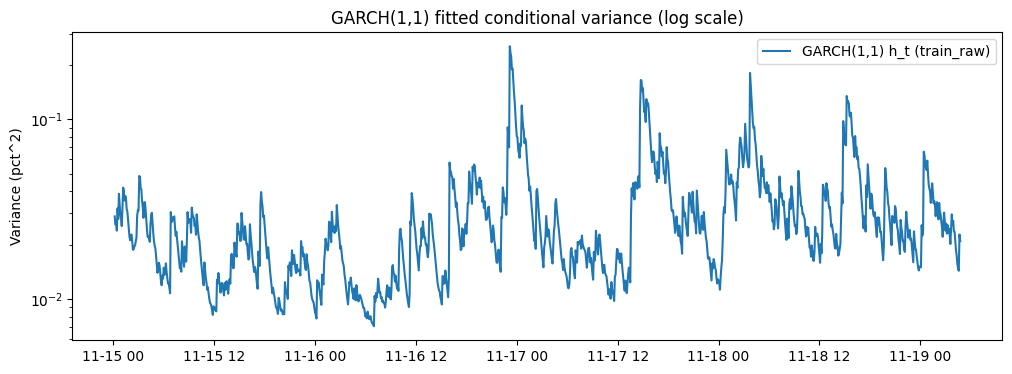

In [39]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def fit_garch11_reparam(ret_pct: pd.Series, eps=1e-6):
    x = ret_pct.values
    var = np.var(x)

    theta0 = np.array([np.log(max(var,1e-8)), 2.0, 0.0])

    def unpack(theta):
        log_hbar, a, b = theta
        hbar = np.exp(log_hbar)
        p = sigmoid(a) * (1.0 - eps)
        s = sigmoid(b)
        alpha = s * p
        beta = (1.0 - s) * p
        omega = hbar * (1.0 - p)
        return omega, alpha, beta, hbar, p, s

    def obj(theta):
        omega, alpha, beta, *_ = unpack(theta)
        h = garch11_filter(x, omega, alpha, beta)
        return gaussian_nll(x, h)

    res = minimize(obj, theta0, method="L-BFGS-B")
    omega, alpha, beta, hbar, p, s = unpack(res.x)
    h = garch11_filter(x, omega, alpha, beta)
    return {
        "omega": omega, "alpha": alpha, "beta": beta,
        "hbar": hbar, "p": p, "share_alpha": s,
        "success": res.success, "message": res.message, "nll": res.fun,
        "h": pd.Series(h, index=ret_pct.index)
    }


garch_fit = fit_garch11_reparam(train_raw["ret_pct"])
print(garch_fit)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_raw.index, garch_fit["h"], label="GARCH(1,1) h_t (train_raw)")
ax.set_yscale("log")
ax.set_title("GARCH(1,1) fitted conditional variance (log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend()
plt.show()


## 3.3 Asymmetry and the leverage effect: GJR-GARCH(1,1)

Empirically, volatility often reacts asymmetrically to returns: negative returns tend to be followed by higher volatility than positive returns of the same magnitude. This phenomenon is commonly called the **leverage effect** (particularly in equities, but asymmetries appear in many markets).

Standard GARCH(1,1) depends on $r_{t-1}^2$ and is therefore symmetric: $+x$ and $-x$ have identical impact. GJR-GARCH introduces an indicator for negative returns:

$$
h_t = \omega + \left(\alpha + \gamma \mathbf{1}\{r_{t-1}<0\}\right)r_{t-1}^2 + \beta h_{t-1}.
$$

A common sufficient stationarity condition is:

$$
\alpha + \beta + \tfrac{1}{2}\gamma < 1,
$$

corresponding to the expected contribution of the asymmetric term when returns are conditionally symmetric.

We enforce this by parameterizing so that $\alpha+\beta+\gamma/2 = p < 1$ by construction.


{'omega': np.float64(0.000840049721540599), 'alpha': np.float64(0.10360146878695016), 'gamma': np.float64(0.06462565124892393), 'beta': np.float64(0.8416721401300936), 'hbar': np.float64(0.03747952208211666), 'p': np.float64(0.9775864345415058), 'weights': array([0.10597679, 0.86096954, 0.03305368]), 'success': True, 'message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', 'nll': np.float64(-540.3694164913383), 'h': dt
2025-11-15 00:10:00+00:00    0.028884
2025-11-15 00:15:00+00:00    0.025759
2025-11-15 00:20:00+00:00    0.025255
2025-11-15 00:25:00+00:00    0.023421
2025-11-15 00:30:00+00:00    0.028949
                               ...   
2025-11-19 04:25:00+00:00    0.016947
2025-11-19 04:30:00+00:00    0.015651
2025-11-19 04:35:00+00:00    0.015299
2025-11-19 04:40:00+00:00    0.026174
2025-11-19 04:45:00+00:00    0.023976
Freq: 5min, Length: 1208, dtype: float64}


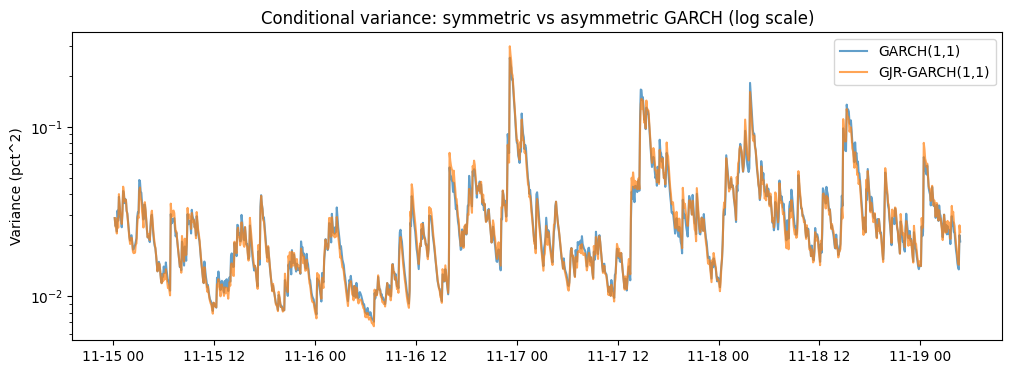

In [40]:
def softmax(v):
    v = np.asarray(v)
    v = v - np.max(v)
    e = np.exp(v)
    return e / np.sum(e)

def fit_gjr_reparam(ret_pct: pd.Series, eps=1e-6):
    x = ret_pct.values
    var = np.var(x)

    theta0 = np.array([np.log(max(var,1e-8)), 2.0, 0.0, 0.0, 0.0]) 

    def unpack(theta):
        log_hbar, a, u1, u2, u3 = theta
        hbar = np.exp(log_hbar)
        p = sigmoid(a) * (1.0 - eps)
        w = softmax([u1,u2,u3])
        alpha = w[0] * p
        beta  = w[1] * p
        gamma = 2.0 * w[2] * p
        omega = hbar * (1.0 - p)
        return omega, alpha, gamma, beta, hbar, p, w

    def obj(theta):
        omega, alpha, gamma, beta, *_ = unpack(theta)
        h = gjr_filter(x, omega, alpha, gamma, beta)
        return gaussian_nll(x, h)

    res = minimize(obj, theta0, method="L-BFGS-B")
    omega, alpha, gamma, beta, hbar, p, w = unpack(res.x)
    h = gjr_filter(x, omega, alpha, gamma, beta)
    return {
        "omega": omega, "alpha": alpha, "gamma": gamma, "beta": beta,
        "hbar": hbar, "p": p, "weights": w,
        "success": res.success, "message": res.message, "nll": res.fun,
        "h": pd.Series(h, index=ret_pct.index)
    }

gjr_fit = fit_gjr_reparam(train_raw["ret_pct"])
print(gjr_fit)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_raw.index, garch_fit["h"], label="GARCH(1,1)", alpha=0.7)
ax.plot(train_raw.index, gjr_fit["h"], label="GJR-GARCH(1,1)", alpha=0.7)
ax.set_yscale("log")
ax.set_title("Conditional variance: symmetric vs asymmetric GARCH (log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend()
plt.show()


## 3.4 EGARCH(1,1): log-variance dynamics and asymmetric news impact

EGARCH (Nelson) models the log variance, which ensures positivity without requiring $\omega, \alpha, \beta \ge 0$:
$$
\log h_t = \omega + \beta \log h_{t-1}
+ \alpha \left( |z_{t-1}| - \mathbb{E}|z| \right) + \gamma z_{t-1},
\quad z_{t-1} = \frac{r_{t-1}}{\sqrt{h_{t-1}}}.
$$

Interpretation:
- $\alpha$ captures the magnitude (“size”) effect of shocks.
- $\gamma$ captures the sign effect (asymmetry).
- $\beta$ captures persistence in log variance.

In finite samples, EGARCH likelihood surfaces can have multiple local optima. A small multi-start strategy is therefore a standard practical approach. The code below includes basic sanity checks to avoid implausible fits.

EGARCH fit: {'omega': np.float64(-0.1772241870988866), 'alpha': np.float64(0.2), 'gamma': np.float64(0.0), 'beta': np.float64(0.95), 'nll': np.float64(-533.9071548464763)}


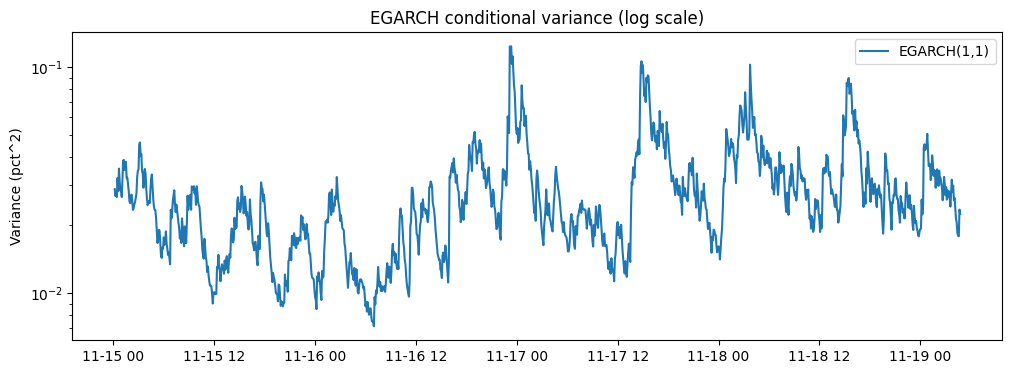

In [41]:
def egarch_filter(r: np.ndarray, omega: float, alpha: float, gamma: float, beta: float, h0=None):
    T = len(r)
    logh = np.empty(T)
    if h0 is None:
        h0 = np.var(r)
    logh[0] = np.log(max(h0, 1e-12))
    Ez = np.sqrt(2.0/np.pi)
    for t in range(1, T):
        h_prev = np.exp(logh[t-1])
        z_prev = r[t-1] / np.sqrt(max(h_prev, 1e-12))
        logh[t] = omega + beta*logh[t-1] + alpha*(np.abs(z_prev) - Ez) + gamma*z_prev
    return np.exp(logh)

def fit_egarch_multistart(ret_pct: pd.Series, starts=None):
    x = ret_pct.values
    var = np.var(x)
    if starts is None:
        starts = []
        for beta in [0.90, 0.95, 0.98]:
            omega = (1-beta) * np.log(max(var,1e-8))
            for alpha in [0.05, 0.10, 0.20]:
                for gamma in [-0.20, -0.10, 0.0]:
                    starts.append(np.array([omega, alpha, gamma, np.arctanh(np.clip(beta, -0.999, 0.999))]))
    bounds = [(-20, 20), (-2, 2), (-2, 2), (-5, 5)]

    def obj(p):
        omega, alpha, gamma, b_raw = p
        beta = np.tanh(b_raw)
        h = egarch_filter(x, omega, alpha, gamma, beta)
        return gaussian_nll(x, h)

    best = None
    for x0 in starts:
        res = minimize(obj, x0, method="L-BFGS-B", bounds=bounds, options={"maxiter": 500})
        if not res.success:
            continue
        omega, alpha, gamma, b_raw = res.x
        beta = np.tanh(b_raw)
        h = egarch_filter(x, omega, alpha, gamma, beta)
        if np.mean(h) > 100 * var:  
            continue
        if np.mean(h) < 0.01 * var: 
            continue
        cand = {"omega": omega, "alpha": alpha, "gamma": gamma, "beta": beta,
                "success": True, "message": res.message, "nll": res.fun,
                "h": pd.Series(h, index=ret_pct.index)}
        if best is None or cand["nll"] < best["nll"]:
            best = cand
    return best

egarch_fit = fit_egarch_multistart(train_raw["ret_pct"])
if egarch_fit is None:
    print("EGARCH: no stable fit found on this sample.")
else:
    print("EGARCH fit:", {k: egarch_fit[k] for k in ["omega","alpha","gamma","beta","nll"]})
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train_raw.index, egarch_fit["h"], label="EGARCH(1,1)")
    ax.set_yscale("log")
    ax.set_title("EGARCH conditional variance (log scale)")
    ax.set_ylabel("Variance (pct^2)")
    ax.legend()
    plt.show()


## 3.5 Out-of-sample one-step-ahead variance forecasts (baselines + GARCH family)

A proper out-of-sample exercise requires:

1. Estimate parameters on the training sample (done above).
2. Carry the filtered state at the end of training into the start of testing.
3. Generate $\hat h_{t+1|t}$ sequentially on the test sample using only information available up to time $t$.

The code below constructs test-period filtered variance paths and then produces aligned one-step-ahead forecasts stored at each index $t$.

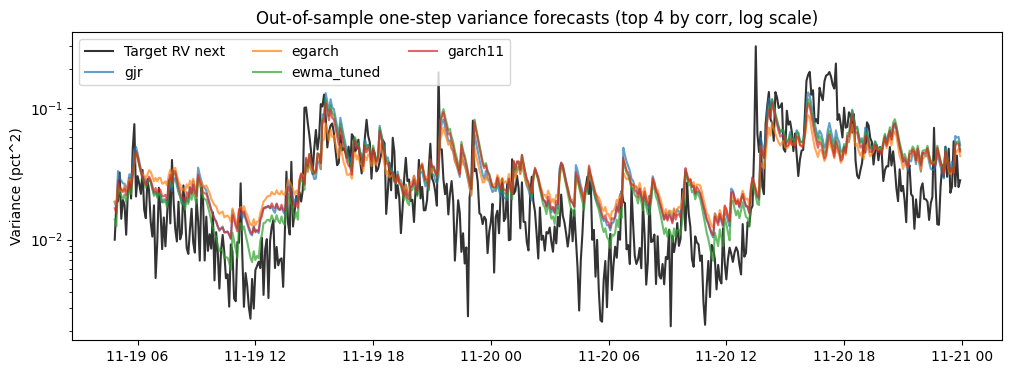

In [42]:
def forecast_path_garch11(ret_pct: pd.Series, fit: dict, h0: float):
    x = ret_pct.values
    omega, alpha, beta = fit["omega"], fit["alpha"], fit["beta"]
    h = np.empty(len(x))
    h[0] = max(h0, 1e-12)
    for t in range(1, len(x)):
        h[t] = omega + alpha*x[t-1]**2 + beta*h[t-1]
        h[t] = max(h[t], 1e-12)
    return pd.Series(h, index=ret_pct.index)

def forecast_path_gjr(ret_pct: pd.Series, fit: dict, h0: float):
    x = ret_pct.values
    omega, alpha, gamma, beta = fit["omega"], fit["alpha"], fit["gamma"], fit["beta"]
    h = np.empty(len(x))
    h[0] = max(h0, 1e-12)
    for t in range(1, len(x)):
        ind = 1.0 if x[t-1] < 0 else 0.0
        h[t] = omega + (alpha + gamma*ind)*x[t-1]**2 + beta*h[t-1]
        h[t] = max(h[t], 1e-12)
    return pd.Series(h, index=ret_pct.index)

def forecast_path_egarch(ret_pct: pd.Series, fit: dict, h0: float):
    x = ret_pct.values
    omega, alpha, gamma, beta = fit["omega"], fit["alpha"], fit["gamma"], fit["beta"]
    h = egarch_filter(x, omega, alpha, gamma, beta, h0=h0)
    return pd.Series(h, index=ret_pct.index)

r_last_train = float(train_raw["ret_pct"].iloc[-1])

h_last_garch = float(garch_fit["h"].iloc[-1])
h0_test_garch = (
    garch_fit["omega"]
    + garch_fit["alpha"] * (r_last_train ** 2)
    + garch_fit["beta"] * h_last_garch
)

h_last_gjr = float(gjr_fit["h"].iloc[-1])
ind_last = 1.0 if r_last_train < 0 else 0.0
h0_test_gjr = (
    gjr_fit["omega"]
    + (gjr_fit["alpha"] + gjr_fit["gamma"] * ind_last) * (r_last_train ** 2)
    + gjr_fit["beta"] * h_last_gjr
)

h_test_garch = forecast_path_garch11(test["ret_pct"], garch_fit, h0_test_garch)
h_test_gjr   = forecast_path_gjr(test["ret_pct"], gjr_fit, h0_test_gjr)

test_fcst = pd.DataFrame(index=test.index)
test_fcst["target_RV_next"] = test["target_RV_next"]

test_fcst["roll_36"] = df_model.loc[test.index, "roll_36"]
test_fcst["ewma_tuned"] = df_model.loc[test.index, "ewma_tuned_fcst"]

r2_t = test["ret_pct"].pow(2)
test_fcst["garch11"] = garch_fit["omega"] + garch_fit["alpha"] * r2_t + garch_fit["beta"] * h_test_garch

ind_neg = (test["ret_pct"] < 0).astype(float)
test_fcst["gjr"] = (
    gjr_fit["omega"]
    + (gjr_fit["alpha"] + gjr_fit["gamma"] * ind_neg) * r2_t
    + gjr_fit["beta"] * h_test_gjr
)

if egarch_fit is not None:
    h_last_eg = float(egarch_fit["h"].iloc[-1])
    logh_last = np.log(max(h_last_eg, 1e-12))
    z_last = r_last_train / np.sqrt(max(h_last_eg, 1e-12))
    Ez = np.sqrt(2.0 / np.pi)
    logh0_test = (
        egarch_fit["omega"]
        + egarch_fit["beta"] * logh_last
        + egarch_fit["alpha"] * (np.abs(z_last) - Ez)
        + egarch_fit["gamma"] * z_last
    )
    h0_test_eg = np.exp(logh0_test)

    h_test_eg = forecast_path_egarch(test["ret_pct"], egarch_fit, h0_test_eg)
    h_t = np.maximum(h_test_eg.values, 1e-12)
    z_t = test["ret_pct"].values / np.sqrt(h_t)
    logh_next = (
        egarch_fit["omega"]
        + egarch_fit["beta"] * np.log(h_t)
        + egarch_fit["alpha"] * (np.abs(z_t) - Ez)
        + egarch_fit["gamma"] * z_t
    )
    test_fcst["egarch"] = np.exp(logh_next)

test_fcst = test_fcst.dropna()

# Plot only top K models to reduce spaghetti
K_plot = min(4, len([c for c in test_fcst.columns if c != "target_RV_next"]))
# Rank by correlation with target for this preliminary view
prelim_corr = {c: test_fcst["target_RV_next"].corr(test_fcst[c]) 
               for c in test_fcst.columns if c != "target_RV_next"}
top_prelim = sorted(prelim_corr, key=lambda x: -prelim_corr[x])[:K_plot]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_fcst.index, test_fcst["target_RV_next"], label="Target RV next", color="black", alpha=0.8)
for c in top_prelim:
    ax.plot(test_fcst.index, test_fcst[c], label=c, alpha=0.7)
ax.set_yscale("log")
ax.set_title(f"Out-of-sample one-step variance forecasts (top {K_plot} by corr, log scale)")
ax.set_ylabel("Variance (pct^2)")
ax.legend(ncol=3)
plt.show()


## 3.6 Diagnostics: standardized residuals

A basic diagnostic for volatility models is whether standardized residuals 
$z_t = \frac{r_t}{\sqrt{h_t}}$
are approximately i.i.d. with unit variance. In practice, heavy tails and skewness are common; nonetheless, lingering autocorrelation in $z_t^2$ indicates that the variance dynamics are not fully captured.

We inspect:
- the distribution of $z_t$, and
- the ACF of $z_t^2$.


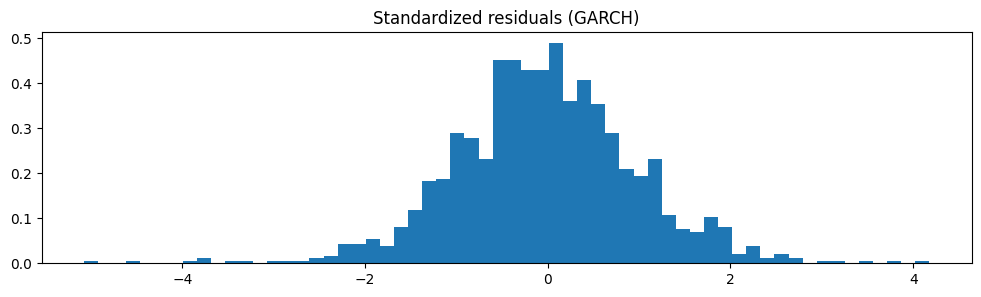

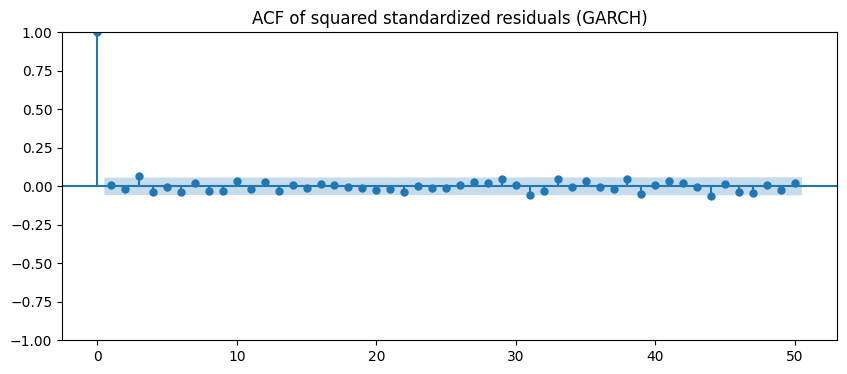

In [43]:
z_garch = train_raw["ret_pct"] / np.sqrt(garch_fit["h"])
z_gjr   = train_raw["ret_pct"] / np.sqrt(gjr_fit["h"])

fig, ax = plt.subplots(figsize=(12, 3))
ax.hist(z_garch, bins=60, density=True)
ax.set_title("Standardized residuals (GARCH)")
plt.show()

fig = plt.figure(figsize=(10, 4))
plot_acf((z_garch**2), lags=50, ax=plt.gca())
plt.title("ACF of squared standardized residuals (GARCH)")
plt.show()


# 4. Realized-volatility tier: HAR-RV

## 4.1 Why regress on realized variance?
When realized measures are available, it can be advantageous to forecast realized variance directly rather than infer it solely from squared returns. Empirically, realized volatility displays strong persistence and "long memory".

The HAR-RV model (Corsi) provides a simple and powerful approximation by combining realized variance components over multiple horizons. In its canonical daily form:

$$
\log RV_{t+1}
= \beta_0
+ \beta_d \log RV_{t}
+ \beta_w \left(\frac{1}{5}\sum_{j=0}^{4}\log RV_{t-j}\right)
+ \beta_m \left(\frac{1}{22}\sum_{j=0}^{21}\log RV_{t-j}\right)
+ u_{t+1}.
$$

We work with $ \log RV $ because:
- it stabilizes variance,
- it mitigates extreme outliers,
- it guarantees positive forecasts after exponentiation.

We optionally add a simple leverage proxy via a lagged negative-return indicator.


HAR frequency: hourly | points: 145 | lags: {'d': 1, 'w': 6, 'm': 24}
                            OLS Regression Results                            
Dep. Variable:             logRV_next   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     9.582
Date:                Thu, 08 Jan 2026   Prob (F-statistic):           2.28e-06
Time:                        19:49:29   Log-Likelihood:                -87.877
No. Observations:                  84   AIC:                             185.8
Df Residuals:                      79   BIC:                             197.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

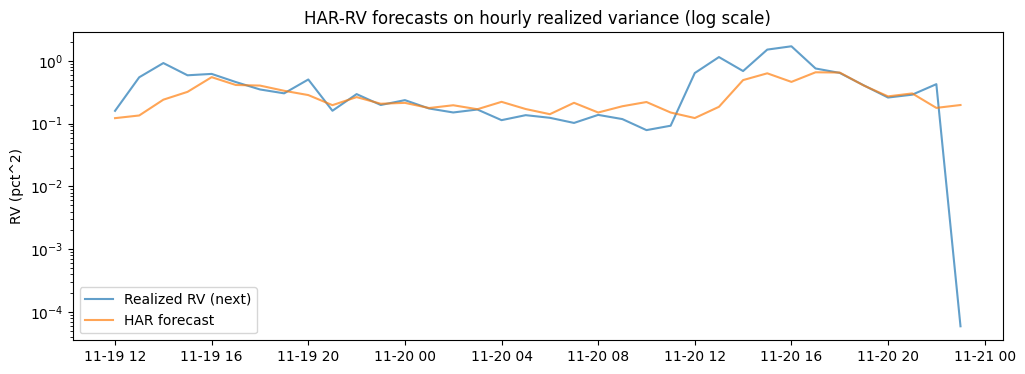

In [44]:
rv_daily = (ret_base**2).resample("1D").sum().dropna() * (RETURN_SCALE**2)
rv_hourly = (ret_base**2).resample("1H").sum().dropna() * (RETURN_SCALE**2)

if len(rv_daily) >= 30:
    rv_har = rv_daily.copy()
    har_name = "daily"
    lags = {"d": 1, "w": 5, "m": 22}
elif len(rv_hourly) >= 72:
    rv_har = rv_hourly.copy()
    har_name = "hourly"
    lags = {"d": 1, "w": 6, "m": 24}
else:
    rv_har = df["RV_pct2"].copy()
    har_name = f"bar({BAR_FREQ})"
    lags = {"d": 1, "w": 12, "m": 72}

print("HAR frequency:", har_name, "| points:", len(rv_har), "| lags:", lags)

eps = 1e-12
logrv = np.log(rv_har + eps)

X = pd.DataFrame(index=logrv.index)
X["logRV_d"] = logrv.shift(lags["d"])
X["logRV_w"] = logrv.rolling(lags["w"]).mean().shift(1)
X["logRV_m"] = logrv.rolling(lags["m"]).mean().shift(1)

# Leverage proxy: negative return on the same grid (if available)
if har_name.startswith("bar"):
    ret_har = df["ret_pct"].reindex(logrv.index)
elif har_name == "hourly":
    ret_har = (df["ret_pct"].resample("1H").sum()).reindex(logrv.index)
else:
    ret_har = (df["ret_pct"].resample("1D").sum()).reindex(logrv.index)

X["neg_ret"] = (ret_har < 0).astype(float).shift(1)

Y = logrv.shift(-1).rename("logRV_next")
har_df = pd.concat([Y, X], axis=1).dropna()

split_idx_har = int(len(har_df) * 0.7)
har_train = har_df.iloc[:split_idx_har]
har_test  = har_df.iloc[split_idx_har:]

X_train = sm.add_constant(har_train.drop(columns=["logRV_next"]))
Y_train = har_train["logRV_next"]
har_model = sm.OLS(Y_train, X_train).fit()
print(har_model.summary())

X_test = sm.add_constant(har_test.drop(columns=["logRV_next"]))
har_pred_log = har_model.predict(X_test)
har_pred_rv = np.exp(har_pred_log)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(har_test.index, np.exp(har_test["logRV_next"]), label="Realized RV (next)", alpha=0.7)
ax.plot(har_test.index, har_pred_rv, label="HAR forecast", alpha=0.7)
ax.set_yscale("log")
ax.set_title(f"HAR-RV forecasts on {har_name} realized variance (log scale)")
ax.set_ylabel("RV (pct^2)")
ax.legend()
plt.show()


# 5. Latent volatility tier: stochastic volatility and regime switching

## 5.1 Stochastic volatility as a latent-state model

A canonical stochastic volatility (SV) specification is:
$$
r_t = \exp\left(\tfrac{1}{2} h_t\right)\varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0,1),
$$
$$
h_t = \mu + \phi (h_{t-1} - \mu) + \sigma \eta_t, \qquad \eta_t \sim \mathcal{N}(0,1),
$$
where $h_t$ is the latent log variance. The persistence parameter $\phi$ typically satisfies $0 < \phi < 1$.

### From SV to a (nearly) linear Gaussian state-space model

Squared returns relate to the latent log variance via:
$$
\log(r_t^2) = h_t + \log(\varepsilon_t^2).
$$

For Gaussian $\varepsilon_t$, $\varepsilon_t^2 \sim \chi_1^2$, so $\log(\varepsilon_t^2)$ has a known distribution with mean and variance:
$$
\mathbb{E}[\log(\chi_1^2)] \approx -1.2704, \qquad
\operatorname{Var}[\log(\chi_1^2)] = \frac{\pi^2}{2}.
$$

A common approximation replaces $\log(\varepsilon_t^2)$ with a Gaussian error term having this mean and variance. Defining
$$
y_t = \log(r_t^2 + \epsilon) - m, \quad m \approx -1.2704,
$$
yields the approximate measurement equation:
$$
y_t \approx h_t + e_t, \qquad e_t \sim \mathcal{N}(0, V), \; V = \pi^2/2.
$$

This creates a linear Gaussian state-space model, enabling likelihood evaluation and filtering via the Kalman filter.

We estimate $(\mu, \phi, \sigma)$ by maximizing the approximate Gaussian likelihood.


{'mu': np.float64(-3.898379318978062), 'phi': np.float64(0.9683715539634599), 'sigma': np.float64(0.22604422357027606), 'nll': 2737.8652624450897}


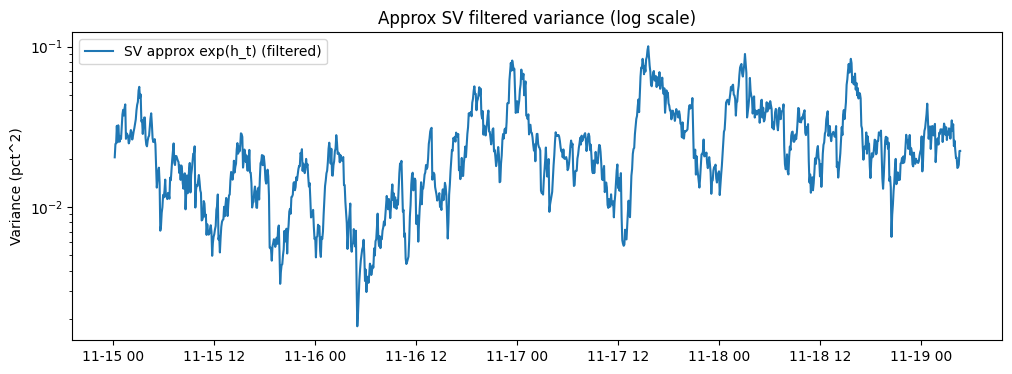

In [45]:
SV_M = -1.2704
SV_V = (np.pi**2) / 2

def sv_kalman_nll(y: np.ndarray, mu: float, phi: float, sigma: float, V: float = SV_V):
    T = len(y)
    a = mu
    P = sigma**2 / max(1e-12, (1.0 - phi**2))
    nll = 0.0
    for t in range(T):
        a_pred = mu + phi * (a - mu)
        P_pred = (phi**2) * P + sigma**2
        v = y[t] - a_pred
        S = P_pred + V
        nll += 0.5 * (np.log(2*np.pi) + np.log(S) + (v**2)/S)
        K = P_pred / S
        a = a_pred + K * v
        P = (1.0 - K) * P_pred
    return float(nll)

def sv_kalman_filter(y: np.ndarray, mu: float, phi: float, sigma: float, V: float = SV_V):
    T = len(y)
    a = mu
    P = sigma**2 / max(1e-12, (1.0 - phi**2))
    a_filt = np.empty(T)
    P_filt = np.empty(T)
    a_pred_arr = np.empty(T)
    P_pred_arr = np.empty(T)
    for t in range(T):
        a_pred = mu + phi*(a - mu)
        P_pred = (phi**2)*P + sigma**2
        v = y[t] - a_pred
        S = P_pred + V
        K = P_pred / S
        a = a_pred + K*v
        P = (1.0 - K)*P_pred
        a_filt[t] = a
        P_filt[t] = P
        a_pred_arr[t] = a_pred
        P_pred_arr[t] = P_pred
    return a_filt, P_filt, a_pred_arr, P_pred_arr

def fit_sv_approx_multistart(ret_pct: pd.Series, starts=None):
    r = ret_pct.values
    y = np.log(r**2 + 1e-12) - SV_M
    y = np.clip(y, -50, 50)

    if starts is None:
        mu0 = float(np.mean(y))
        starts = []
        for phi in [0.80, 0.90, 0.95, 0.98, 0.995]:
            for sigma in [0.05, 0.10, 0.20, 0.40]:
                starts.append((mu0, phi, sigma))

    best = None
    for mu0, phi0, sigma0 in starts:
        # optimize over (mu, logit_phi, log_sigma)
        x0 = np.array([mu0, np.log(phi0/(1-phi0)), np.log(sigma0)])
        bounds = [(-50, 50), (-10, 10), (-10, 3)]  # log_sigma lower bound keeps sigma >= ~4.5e-5

        def unpack(p):
            mu = p[0]
            phi = sigmoid(p[1]) * 0.999
            sigma = np.exp(p[2])
            return mu, phi, sigma

        def obj(p):
            mu, phi, sigma = unpack(p)
            return sv_kalman_nll(y, mu, phi, sigma, V=SV_V)

        res = minimize(obj, x0, method="L-BFGS-B", bounds=bounds)
        if not res.success:
            continue
        mu, phi, sigma = unpack(res.x)
        a_filt, P_filt, a_pred, P_pred = sv_kalman_filter(y, mu, phi, sigma, V=SV_V)
        cand = {
            "mu": mu, "phi": phi, "sigma": sigma,
            "success": True, "message": res.message, "nll": res.fun,
            "h_filt": pd.Series(a_filt, index=ret_pct.index),
            "P_filt": pd.Series(P_filt, index=ret_pct.index)
        }
        if best is None or cand["nll"] < best["nll"]:
            best = cand
    return best

sv_fit = fit_sv_approx_multistart(train["ret_pct"])
if sv_fit is None:
    print("SV approx: no stable fit found.")
else:
    print({k: sv_fit[k] for k in ["mu","phi","sigma","nll"]})
    sv_var_filt = np.exp(sv_fit["h_filt"])
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train.index, sv_var_filt, label="SV approx exp(h_t) (filtered)")
    ax.set_yscale("log")
    ax.set_title("Approx SV filtered variance (log scale)")
    ax.set_ylabel("Variance (pct^2)")
    ax.legend()
    plt.show()

## 5.2 One-step-ahead SV variance forecasts on the test set

For Gaussian $h_{t+1}$ with mean $a$ and variance $P$,
$$
\mathbb{E}[\exp(h_{t+1})] = \exp\left(a+\tfrac{1}{2}P\right).
$$
This provides a natural mapping from the filtered state distribution to a variance forecast.

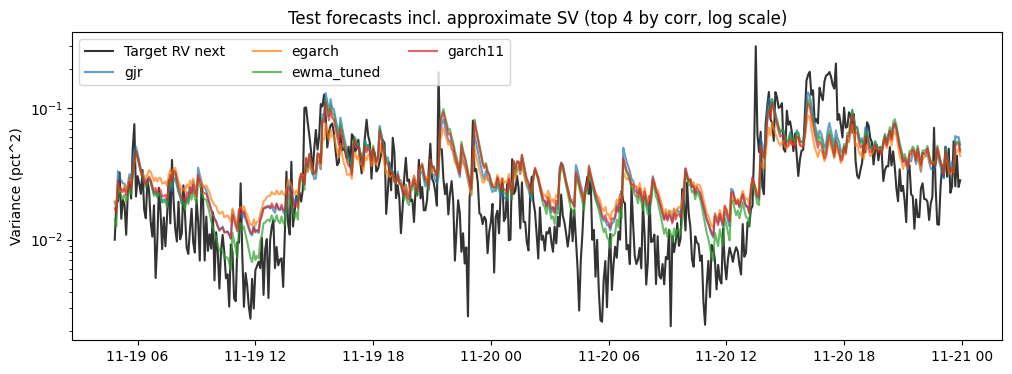

In [46]:
def sv_forecast_next_variance(ret_pct: pd.Series, params: dict):
    r = ret_pct.values
    y = np.log(r**2 + 1e-12) - SV_M
    y = np.clip(y, -50, 50)

    mu, phi, sigma = params["mu"], params["phi"], params["sigma"]
    V = SV_V

    T = len(y)
    a = mu
    P = sigma**2 / max(1e-12, (1.0 - phi**2))

    var_next = np.empty(T)
    for t in range(T):
        # predict h_t
        a_pred = mu + phi*(a - mu)
        P_pred = (phi**2)*P + sigma**2

        # update with y_t
        v = y[t] - a_pred
        S = P_pred + V
        K = P_pred / S
        a = a_pred + K*v
        P = (1.0 - K)*P_pred

        # next-step prediction moments for h_{t+1}
        a_next = mu + phi*(a - mu)
        P_next = (phi**2)*P + sigma**2

        # E[exp(h_{t+1})] for Gaussian h_{t+1}
        var_next[t] = np.exp(a_next + 0.5*P_next)

    return pd.Series(var_next, index=ret_pct.index)

if sv_fit is not None:
    sv_fcst_test = sv_forecast_next_variance(test["ret_pct"], sv_fit)
    test_fcst["sv_approx"] = sv_fcst_test
    test_fcst = test_fcst.dropna()

    # Plot only top K models to reduce spaghetti
    K_plot_sv = min(4, len([c for c in test_fcst.columns if c != "target_RV_next"]))
    sv_corr = {c: test_fcst["target_RV_next"].corr(test_fcst[c]) 
               for c in test_fcst.columns if c != "target_RV_next"}
    top_sv = sorted(sv_corr, key=lambda x: -sv_corr[x])[:K_plot_sv]
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(test_fcst.index, test_fcst["target_RV_next"], label="Target RV next", color="black", alpha=0.8)
    for c in top_sv:
        ax.plot(test_fcst.index, test_fcst[c], label=c, alpha=0.7)
    ax.set_yscale("log")
    ax.set_title(f"Test forecasts incl. approximate SV (top {K_plot_sv} by corr, log scale)")
    ax.set_ylabel("Variance (pct^2)")
    ax.legend(ncol=3)
    plt.show()


## 5.3 Regime switching: Markov switching variance

Volatility dynamics can exhibit **distinct regimes** (e.g., calm vs turbulent markets). A classical discrete-state approach is a Markov regime-switching model:

- A latent regime $S_t \in \{1,2\}$ evolves as a Markov chain.
- Conditional on $S_t$, returns have regime-dependent variance.

This can be viewed as a parsimonious model for abrupt volatility shifts. The `statsmodels` implementation below estimates:
- regime probabilities $P(S_t = k \mid \mathcal{F}_T)$ (smoothed probabilities),
- regime-dependent variances,
- and transition probabilities.


                        Markov Switching Model Results                        
Dep. Variable:                ret_pct   No. Observations:                 1207
Model:               MarkovRegression   Log Likelihood                 528.174
Date:                Thu, 08 Jan 2026   AIC                          -1044.349
Time:                        19:49:31   BIC                          -1013.773
Sample:                    11-15-2025   HQIC                         -1032.835
                         - 11-19-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.004     -0.773      0.440      -0.012       0.005
sigma2         0.0145      0.001     10.252      0.0

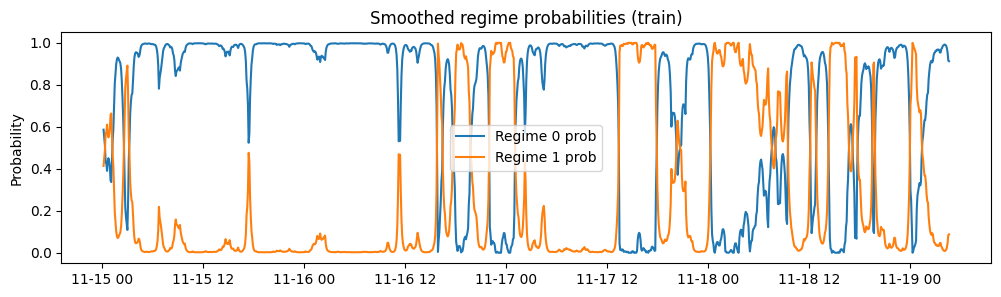

Variance keys: ['sigma2[0]', 'sigma2[1]']


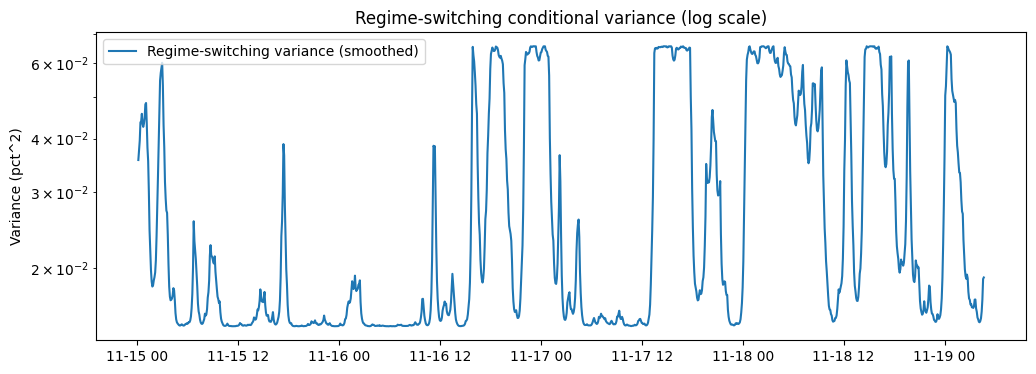

In [47]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

mr = MarkovRegression(train["ret_pct"], k_regimes=2, trend="c", switching_variance=True)
mr_res = mr.fit(disp=False)
print(mr_res.summary())

probs = mr_res.smoothed_marginal_probabilities
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(probs.index, probs[0], label="Regime 0 prob")
ax.plot(probs.index, probs[1], label="Regime 1 prob")
ax.set_title("Smoothed regime probabilities (train)")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

params = mr_res.params
var_keys = [k for k in params.index if "sigma2" in k or "variance" in k]
print("Variance keys:", var_keys)

if len(var_keys) >= 2:
    v0 = float(params[var_keys[0]])
    v1 = float(params[var_keys[1]])
    var_rs = probs[0]*v0 + probs[1]*v1
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(var_rs.index, var_rs, label="Regime-switching variance (smoothed)")
    ax.set_yscale("log")
    ax.set_title("Regime-switching conditional variance (log scale)")
    ax.set_ylabel("Variance (pct^2)")
    ax.legend()
    plt.show()

## 6. Proper comparison: loss functions and out-of-sample evaluation

### 6.1 Why proper scoring rules matter

Evaluating volatility models using correlation alone can be misleading: a model can be highly correlated with the target yet systematically biased. A principled evaluation uses loss functions aligned with the statistical decision problem.

We report:
- MSE on variance (sensitive to large outliers)
- QLIKE (proper for variance forecasts; robust in realized-variance settings)
- correlation (interpretability only; not a proper scoring rule)

The key benchmark for ranking is the **mean QLIKE**.

In [48]:
def mse(y_true: pd.Series, y_pred: pd.Series) -> float:
    a = pd.concat([y_true, y_pred], axis=1).dropna()
    return float(np.mean((a.iloc[:,0] - a.iloc[:,1])**2))

def qlike(y_true: pd.Series, y_pred: pd.Series, eps=1e-12) -> float:
    a = pd.concat([y_true, y_pred], axis=1).dropna()
    return qlike_loss(a.iloc[:,0], a.iloc[:,1], eps=eps)

models_to_eval = [c for c in test_fcst.columns if c != "target_RV_next"]
metrics = []
for m in models_to_eval:
    metrics.append({
        "model": m,
        "MSE": mse(test_fcst["target_RV_next"], test_fcst[m]),
        "QLIKE": qlike(test_fcst["target_RV_next"], test_fcst[m]),
        "corr": test_fcst["target_RV_next"].corr(test_fcst[m]),
    })

metrics_df = pd.DataFrame(metrics).sort_values("QLIKE")
metrics_df

,model,MSE,QLIKE,corr
1,ewma_tuned,0.000833,0.229216,0.616372
3,gjr,0.000772,0.243150,0.659570
2,garch11,0.000851,0.256134,0.611049
4,egarch,0.000888,0.276733,0.625611
5,sv_approx,0.000876,0.291222,0.610039
0,roll_36,0.000940,0.307488,0.547730


## 6.2 Cumulative QLIKE for stability diagnostics

Mean loss summarizes performance, but volatility forecasting often involves rare but extreme episodes. Plotting cumulative loss highlights whether a model:
- wins steadily, or
- wins mostly by avoiding a few catastrophic forecast errors.

Lower cumulative QLIKE is better.

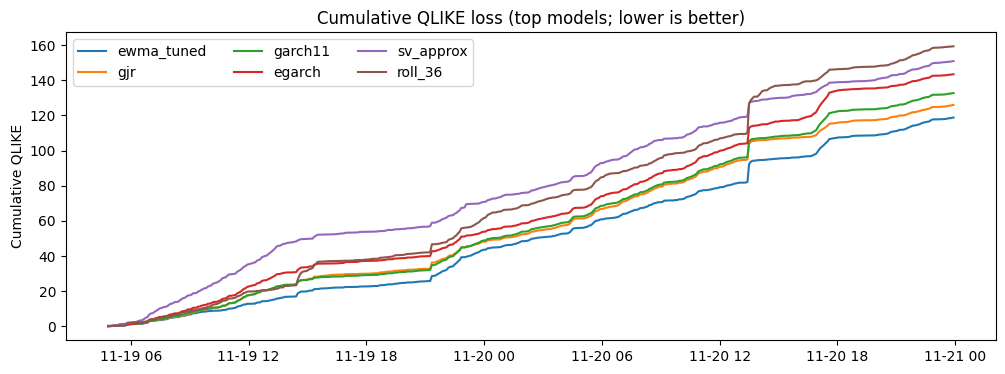

In [49]:

loss_df = pd.DataFrame(index=test_fcst.index)
for m in models_to_eval:
    y = np.maximum(test_fcst["target_RV_next"].values, 1e-12)
    h = np.maximum(test_fcst[m].values, 1e-12)
    ratio = y / h
    loss_df[m] = ratio - np.log(ratio) - 1.0


K = min(6, len(models_to_eval))
top_models = metrics_df["model"].head(K).tolist()

cum = loss_df[top_models].cumsum()

fig, ax = plt.subplots(figsize=(12, 4))
for m in top_models:
    ax.plot(cum.index, cum[m], label=m)
ax.set_title("Cumulative QLIKE loss (top models; lower is better)")
ax.set_ylabel("Cumulative QLIKE")
ax.legend(ncol=3)
plt.show()


## 6.3 Calibration: forecast vs realized variance

A variance forecast is well calibrated if realized variance is (approximately) proportional to the forecast on average. A visual diagnostic is a log-log scatter of forecasts against realized outcomes.

We add a 45-degree line corresponding to perfect calibration (forecast equals realized: $y = x$). Because variance data are heavy-tailed and concentrated near zero, we use a hexbin density plot on log scales.


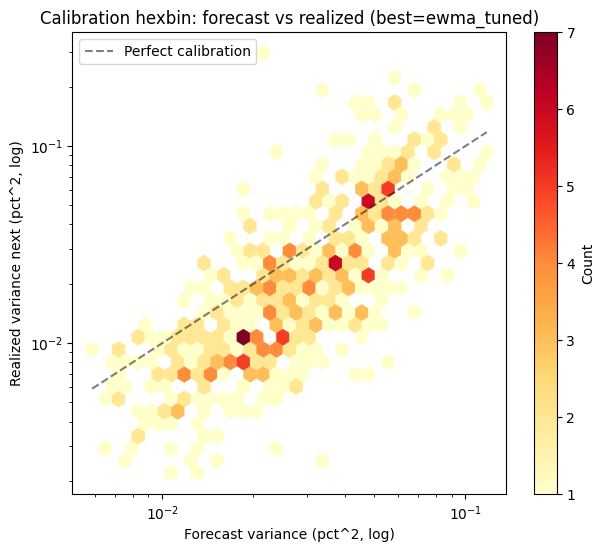

In [50]:
best_model = metrics_df.iloc[0]["model"] if len(metrics_df) else None
if best_model is not None:
    x = test_fcst[best_model].values
    y = test_fcst["target_RV_next"].values
    
    mask = (x > 0) & (y > 0)
    x_pos, y_pos = x[mask], y[mask]
    
    fig, ax = plt.subplots(figsize=(7, 6))
    hb = ax.hexbin(x_pos, y_pos, gridsize=30, cmap="YlOrRd", mincnt=1,
                   xscale="log", yscale="log", linewidths=0.2)
    
    lims = [max(x_pos.min(), y_pos.min()), min(x_pos.max(), y_pos.max())]
    ax.plot(lims, lims, "k--", alpha=0.5, label="Perfect calibration")
    
    ax.set_title(f"Calibration hexbin: forecast vs realized (best={best_model})")
    ax.set_xlabel("Forecast variance (pct^2, log)")
    ax.set_ylabel("Realized variance next (pct^2, log)")
    plt.colorbar(hb, ax=ax, label="Count")
    ax.legend(loc="upper left")
    plt.show()

 # What the code is meant to teach

 1. **Measurement first:** without a thoughtful variance proxy (ideally realized measures), “volatility forecasting” becomes largely an exercise in fitting noise.
 2. **Indexing discipline matters:** variance forecasting is fundamentally about information sets; aligning timestamps and avoiding leakage is non‑negotiable.
 3. **Baselines are powerful:** rolling and EWMA often provide strong benchmarks; any sophisticated method should justify itself relative to these.
 4. **GARCH vs realized‑vol models:** GARCH learns variance from returns; HAR‑RV learns persistence directly from realized measures and often excels when intraday data are available.
 5. **Latent‑state models broaden the lens:** stochastic volatility and regime switching provide alternative structural explanations for persistence and abrupt changes.
 6. **Use proper loss functions:** QLIKE is a standard choice for variance forecasts with noisy realized targets; correlations alone are not sufficient.